In [ ]:
#tf-idf set up

from collections import Counter
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from functions import remove_stopwords

texts = []
textnames = []
folder = '/srv/data/EPtuningTexts'
for file in os.listdir(folder):
    path = os.path.join(folder,file)
    f = open(path,'r')
    data = f.readlines()[0]
    texts.append(data)
    name = file.split('.')[0]
    textnames.append(name)
    f.close()
 
tokenized = []
for text in texts:
    words = []
    text = text.split(' ')
    #tokenize roughly by white space, can update later
    list = remove_stopwords(text)
    for word in list:
        if len(word) != 0:
            words.append(word[0].lower())
    #TODO: smarter way of getting a list of words while still using remove method?
    tokenized.append(words)

wordcounts = [Counter(t) for t in tokenized]
df = pd.DataFrame(wordcounts, index=[name for name in textnames]).fillna(0)

: 

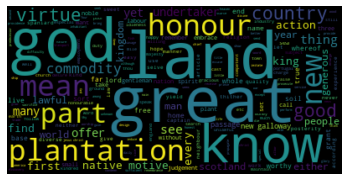

In [30]:
#term frequency & word clouds through wordcloud library processing

#fileTF = input("Input the TCP ID of the file here:")
fileTF = "A01932"
textstring = ' '.join(tokenized[textnames.index(fileTF)]).lower()
#textlist = tokenized[textnames.index(fileTF)]

wordcloud = WordCloud(stopwords=STOPWORDS, collocations=True).generate(textstring)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

textdict = wordcloud.process_text()
wordfreq={k: v for k, v in sorted(textdict.items(),reverse=True, key=lambda item: item[1])}
relfrequ=wordcloud.words_

print(list(wordfreq.items())[:10])
print(list(relfreq.items())[:10])

In [ ]:
# word clouds through manual term frequency

corpus = [' '.join(t for t in tokenized)]
count = CountVectorizer(stop_words=STOPWORDS, ngram_range=(1,3))


textstring2=cv

In [3]:
# using transformer, generate table to compare tf-idfs across multiple texts
# code accessed from EarlyPrint+Python jupyter notebook

basetext = input("input the TCP ID of the text you'd like to sort by: ")
# normalization turned off
# sublinear term frequency scaling turned on (takes log of term frequencies and can help to de-emphasize function words like pronouns and articles.
tfidf = TfidfTransformer(norm=None, sublinear_tf=True)
results = tfidf.fit_transform(df)

table = pd.DataFrame(results.toarray(), index=df.index, columns=df.columns)

# columns are texts
# use .head(30) to show only the top 30 terms
# sort using words with highest tfidf scores in A01932 as an example
table.T.sort_values(by=[basetext], ascending=False).head(25)

,A01932,A02495,A03149,A04813,A07886,A10821,A12458,A12460,A12466,A13290,...,A66847,A68617,A69149,A71305,A71306,A71307,A77422,A83297,B00052,B00963
aᵒ,0.0,0.000000,21.431536,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
boterus,0.0,0.000000,16.088661,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
gules,0.0,0.000000,14.827404,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,3.197225,0.0,0.0,0.0,0.0
sleid,0.0,0.000000,14.738756,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
brandenbourg,0.0,0.000000,14.015802,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
lorreine,0.0,0.000000,14.015802,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
anᵒ,0.0,0.000000,13.591466,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
guicciard,0.0,0.000000,13.358954,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
rodolphus,0.0,0.000000,13.358954,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
savus,0.0,0.000000,13.110394,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [23]:
# transformer version, but outputting tf-idf values for a single text, easier viewing

dataset = []
for text in tokenized:
    dataset.append(' '.join(text))

transformer = TfidfTransformer(norm=None, sublinear_tf=True, use_idf=True)
cv = CountVectorizer()
wc = cv.fit_transform(dataset)
wctrans = transformer.fit_transform(wc)

single = pd.DataFrame(wctrans[textnames.index(basetext)].T.todense(), index=cv.get_feature_names_out(), columns=[basetext + " TF-IDF"])
single = single.sort_values(basetext + ' TF-IDF', ascending=False)

print (single.head(25))

              A03149 TF-IDF
aᵒ                21.431536
boterus           16.088661
gules             14.827404
sleid             14.738756
brandenbourg      14.015802
lorreine          14.015802
anᵒ               13.591466
guicciard         13.358954
rodolphus         13.358954
sleidan           13.110394
savus             13.110394
munster           13.106608
bara              13.082780
alphonso          12.912613
pyrenean          12.843406
adrianus          12.775253
antigonus         12.775253
camden            12.662535
saxony            12.628191
grimston          12.611257
paradin           12.555037
genoy             12.555037
frederick         12.399779
florus            12.389113
luxenbourg        12.241562
